In [493]:
import numpy as np
import pylab as plt
import torch
import scipy.stats as stats
import scipy
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import swyft
import random
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
sns.set(style='ticks', context='notebook', font='serif', 
        font_scale=1.5, palette='deep')
rc_params = {'backend': 'pdf',
             'axes.labelsize': 24,
             'axes.titlesize': 32,
             'font.size': 18,
             'legend.fontsize': 18,
             'xtick.labelsize': 24,
             'ytick.labelsize': 24,
             'font.family': 'serif',
             'font.sans-serif': ['Bitstream Vera Sans'],
             'font.serif': ['Times New Roman'],
             'text.usetex':True,
            }
plt.rcParams["text.usetex"] = "true"

DEVICE = 'gpu' if torch.cuda.is_available() else 'cpu'

In [550]:
# Define Simulator
class Simulator(swyft.Simulator):
    def __init__(self, fref, psd, gamma, T_obs, N_bins, bounds=None):
        super().__init__()
        
        self.fref      = fref
        self.psd       = psd
        self.gamma     = gamma
        self.T_obs     = T_obs
        
        self.transform_samples = swyft.to_numpy32
        self.N_bins = N_bins
        self.freq = np.linspace(f_low, f_high, N_bins)
        self.sample_z = swyft.RectBoundSampler([stats.uniform(-12,5), #omega
                                                stats.uniform(0,3)], #alpha
                                                bounds = bounds) #bounds changes range of the prior

    def psd_interp(self):
        return scipy.interpolate.interp1d(self.psd[:,0], self.psd[:,1])(self.freq)
    
    def gamma_interp(self):
        return scipy.interpolate.interp1d(self.gamma[:, 0], self.gamma[:, 1])(self.freq)
    
    def sigma(self):
        numerator = (20*pi**2*self.freq**3)**2 * self.psd_interp()**2
        denomenator = (3*H0**2)**2 * 8*self.gamma_interp()**2
        T = 1/(self.freq[1]-self.freq[0])
        N = 2*self.T_obs // T - 1
        return np.sqrt(numerator/denomenator/N)
    
    def C_groundtruth(self, z):
        Omega_ref = 10**z[0]
        alpha     = z[1]
        C_hat_ij = Omega_ref * (self.freq/self.fref)**alpha
        return C_hat_ij
    
    def build(self, graph):
        z = graph.node('z', self.sample_z)
        m = graph.node('m', self.C_groundtruth, z)
        x = graph.node("x", lambda m: m + np.random.normal(0, self.sigma()), m)
        #x = graph.node("x", lambda m: m + 0, m) #Ground truth wih sigma noise
        #sigma = graph.node('sigma',self.sigma)

In [551]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

# Define AE

class AE(swyft.SwyftModule):
    def __init__(self):
        
        super().__init__()
        marginals = ((0, 1),)

        self.summarizer =  nn.Sequential(
            nn.Linear(4076, 2048),
            nn.GELU(),
            nn.Linear(2048, 1024),
            nn.GELU(),
            nn.Linear(1024, 512),
            nn.GELU(),
            nn.Linear(512, 256),
            nn.GELU(),
            nn.Linear(256, 64),
            nn.GELU(),
            nn.Linear(64, 16),
            nn.GELU(),
            nn.Linear(16, 2),
  
        )
        self.logratios1 = swyft.LogRatioEstimator_1dim(
            num_features=1,  # Number of features in compressed x (simulated observation)
            num_params=2,    # Two parameters to infer: alpha and omega
            varnames='z',  # Names of the parameters
            num_blocks=4     # Number of neural network blocks
        )
        self.logratios2 = swyft.LogRatioEstimator_Ndim(num_features = 2, 
                                                       marginals = marginals, varnames = 'z', num_blocks = 4,  dropout = 0.0)

    def forward(self, A, B):
        # Forward pass: encode, reparameterize
        s = self.summarizer(A['x'])
        #s = s.unsqueeze(-1)
        logratios1 = self.logratios1(s.unsqueeze(-1), B['z'])
        logratios2 = self.logratios2(s, B['z'])
        return logratios1, logratios2
    
    

In [562]:
# Define simulator parameters
f_low = 10
f_high = 1024
N_bins = 4076
freq = np.linspace(f_low, f_high, N_bins)
pi = np.pi
sqrt = np.sqrt
H100 = 3.241e-18
h    = 0.679
H0   = h * H100

# Sample from Simulator

n_samples = 5_000
fref = 25
CE_PSD = np.genfromtxt("../Lexi/data/cosmic_explorer_40km_for_paper.txt")
CE_PSD[0, 0]  = 4.99999999999999999
CE_PSD[:, 1] = CE_PSD[:, 1]**2
gamma_HL = np.genfromtxt("../Lexi/data/gamma_HL.txt")
T_obs = 365 * 24 * 3600

sim = Simulator(fref, CE_PSD, gamma_HL, T_obs, N_bins, bounds=None)
#obs = sim.sample(conditions = {'z': np.array([5e-8, 2.1])})
samples = sim.sample(n_samples) 

100%|██████████| 5000/5000 [00:07<00:00, 663.67it/s]


In [563]:
samples['x'] = np.log10(np.abs(samples['x']))
# Standardize data!
mu_f = np.mean(samples['x'], axis=0)
sigma_f = np.std(samples['x'], axis=0)

samples['x'] = (samples['x']-mu_f)/sigma_f

In [564]:
trainer = swyft.SwyftTrainer(accelerator=DEVICE, precision=64)

# Step 4: Prepare the data module for training
dm = swyft.SwyftDataModule(samples, val_fraction = 0.2, num_workers = 3, batch_size = 128)
lr_monitor = LearningRateMonitor(logging_interval='step')
# Step 5: Instantiate and train the network
network = AE()
trainer.fit(network, dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint

  | Name       | Type                   | Params
------------------------------------------------------
0 | summarizer | Sequential             | 11.1 M
1 | logratios1 | LogRatioEstimator_1dim | 69.1 K
2 | logratios2 | LogRatioEstimator_Ndim | 34.7 K
------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
89.803    Total estimated model params size (MB)


Epoch 0:  80%|████████  | 32/40 [00:06<00:01,  4.78it/s, loss=0.00221, v_num=75]
Validation: 0it [00:00, ?it/s]
Epoch 1:  80%|████████  | 32/40 [00:07<00:01,  4.40it/s, loss=0.000983, v_num=75, val_loss=0.000259]
Validation: 0it [00:00, ?it/s]
Epoch 2:  80%|████████  | 32/40 [00:06<00:01,  4.69it/s, loss=0.0024, v_num=75, val_loss=0.000829]  
Validation: 0it [00:00, ?it/s]
Epoch 3:  80%|████████  | 32/40 [00:06<00:01,  4.70it/s, loss=0.0032, v_num=75, val_loss=0.00101] 
Validation: 0it [00:00, ?it/s]
Epoch 4:  80%|████████  | 32/40 [00:06<00:01,  4.60it/s, loss=0.00134, v_num=75, val_loss=0.00204]
Validation: 0it [00:00, ?it/s]
Epoch 5:  80%|████████  | 32/40 [00:06<00:01,  4.63it/s, loss=0.00414, v_num=75, val_loss=0.00136]
Validation: 0it [00:00, ?it/s]
Epoch 5: 100%|██████████| 40/40 [00:08<00:00,  4.48it/s, loss=0.00414, v_num=75, val_loss=0.00137]
Reloading best model: /home/haowen.zhong/SBI/SBI_SGWB_DSMMA/Haowen/lightning_logs/version_75/checkpoints/epoch=0-step=32.ckpt


In [567]:
# Define priors
omega_prior = stats.uniform(-12, 5)  # Log-uniform distribution for omega
alpha_prior = stats.uniform(0, 3)            # Uniform distribution for alpha

# Specify obs only once!
obs = swyft.Sample(x=samples['x'][33], z=samples['z'][33] ) 
# Sample 1000 points from the priors
z_omega = omega_prior.rvs(30000)
z_alpha = alpha_prior.rvs(30000)

z_samps = np.column_stack((z_omega, z_alpha))

# Create prior samples
prior_samples = swyft.Samples(z = z_samps)
predictions = trainer.infer(network, obs, prior_samples)


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting DataLoader 0: 100%|██████████| 30/30 [00:11<00:00,  2.68it/s]


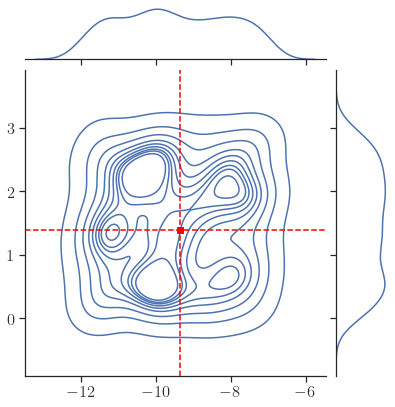

In [566]:
prior = np.asarray(predictions[1].params).reshape([30000,2])
ln_r_2d = np.asarray(predictions[1].logratios)
r_2d = np.exp(ln_r_2d).reshape(-1)
post_idx = np.random.choice(np.arange(0, 30000, 1), size=500, p = r_2d/np.sum(r_2d))

sns.jointplot(x=prior[post_idx, 0], y=prior[post_idx, 1], kind="kde")
plt.axvline(obs['z'][0], color="red", ls="--")
plt.axhline(obs['z'][1], color="red", ls="--")
plt.plot(obs['z'][0], obs['z'][1], "s", color="red")

Text(0.5, 0, '$\\alpha$')

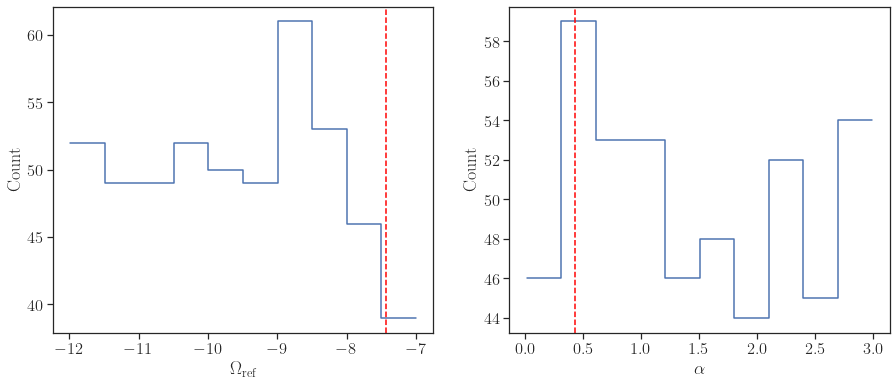

In [508]:
plt.figure(figsize=(15, 6))
plt.subplot(121)
sns.histplot(prior[post_idx, 0], element="step", fill=False)
plt.axvline(obs['z'][0], color="red", ls="--")
plt.xlabel(r"$\Omega_\mathrm{ref}$")
plt.subplot(122)
sns.histplot(prior[post_idx, 1], element="step", fill=False)
plt.axvline(obs['z'][1], color="red", ls="--")
plt.xlabel(r"$\alpha$")

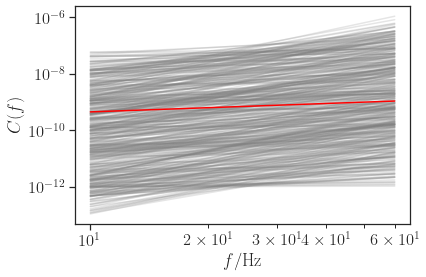

In [465]:
for i in range(500):
    plt.loglog(sim.freq, 10**prior[post_idx, 0][i] * (sim.freq/sim.fref)**prior[post_idx, 1][i], alpha=0.2, color="gray")
plt.xlabel(r"$f$/Hz")
plt.ylabel(r"$C(f)$")
plt.subplots_adjust(wspace=0.5)
plt.loglog(sim.freq, 10**obs['z'][0]*(sim.freq/sim.fref)**obs['z'][1], color="red")

## Second Round

In [439]:
sim = Simulator(fref, CE_PSD, gamma_HL, T_obs, bounds=torch.tensor([[-11.5, -11], [0, 3]]))
#obs = sim.sample(conditions = {'z': np.array([5e-8, 2.1])})
samples = sim.sample(n_samples) 
samples['x'] = np.log10(np.abs(samples['x']))

100%|██████████| 10000/10000 [00:03<00:00, 2514.88it/s]


In [440]:
x_samples = np.log10(np.abs(samples['x']))
z_samples = samples['z']

scaler_x = StandardScaler()
x_samples = scaler_x.fit_transform(x_samples)

samples['x'] = x_samples
samples['z'] = z_samples

trainer = swyft.SwyftTrainer(accelerator=DEVICE, precision=64)

# Step 4: Prepare the data module for training
dm = swyft.SwyftDataModule(samples)

# Step 5: Instantiate and train the network
network = AE()
trainer.fit(network, dm)

# Define priors
omega_prior = stats.uniform(-11.5, 0.5)  # Log-uniform distribution for omega
alpha_prior = stats.uniform(0, 3)            # Uniform distribution for alpha

# Sample 1000 points from the priors
z_omega = omega_prior.rvs(20000)
z_alpha = alpha_prior.rvs(20000)

z_samps = np.column_stack((z_omega, z_alpha))

# Create prior samples
prior_samples = swyft.Samples(z = z_samps)
predictions = trainer.infer(network, obs, prior_samples)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/haowen.zhong/.conda/envs/Hierfit/lib/python3.11/site-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint

  | Name       | Type                   | Params
------------------------------------------------------
0 | summarizer | Sequential             | 2.3 M 
1 | logratios2 | LogRatioEstimator_Ndim | 34.7 K
------------------------------------------------------
2.3 M     Trainable params
0         Non-trainable params
2.3 M     Total params
18.782    Total estimated model params size (MB)


/home/haowen.zhong/.conda/envs/Hierfit/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/haowen.zhong/.conda/envs/Hierfit/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:  80%|███████▉  | 250/313 [00:09<00:02, 26.05it/s, loss=-1.09, v_num=63] 
Validation: 0it [00:00, ?it/s]
Epoch 1:  80%|███████▉  | 250/313 [00:09<00:02, 25.05it/s, loss=-1.13, v_num=63, val_loss=1.680] 
Validation: 0it [00:00, ?it/s]
Epoch 2:  80%|███████▉  | 250/313 [00:10<00:02, 24.80it/s, loss=-1.17, v_num=63, val_loss=2.240]
Validation: 0it [00:00, ?it/s]
Epoch 3:  80%|███████▉  | 250/313 [00:09<00:02, 26.13it/s, loss=-1.02, v_num=63, val_loss=1.910] 
Validation: 0it [00:00, ?it/s]
Epoch 4:  80%|███████▉  | 250/313 [00:09<00:02, 26.37it/s, loss=-1.17, v_num=63, val_loss=-1.07] 
Validation: 0it [00:00, ?it/s]
Epoch 5:  80%|███████▉  | 250/313 [00:10<00:02, 24.27it/s, loss=-1.17, v_num=63, val_loss=3.800]
Validation: 0it [00:00, ?it/s]
Epoch 6:  80%|███████▉  | 250/313 [00:10<00:02, 23.85it/s, loss=-1.13, v_num=63, val_loss=-.953]
Validation: 0it [00:00, ?it/s]
Epoch 7:  80%|███████▉  | 250/313 [00:09<00:02, 25.46it/s, loss=-1.13, v_num=63, val_loss=5.920]
Validation: 0it [00

/home/haowen.zhong/.conda/envs/Hierfit/lib/python3.11/site-packages/swyft/lightning/utils.py:535: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(self.

Reloading best model: /home/haowen.zhong/SBI/SBI_SGWB_DSMMA/Haowen/lightning_logs/version_63/checkpoints/epoch=8-step=2250.ckpt
Predicting DataLoader 0: 100%|██████████| 20/20 [00:00<00:00, 22.75it/s]


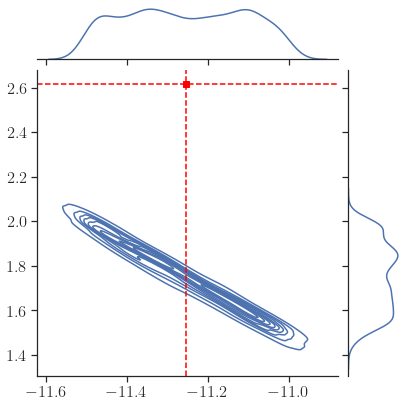

In [441]:
prior = np.asarray(predictions.params).reshape([20000,2])
ln_r_2d = np.asarray(predictions.logratios)
r_2d = np.exp(ln_r_2d).reshape(-1)
post_idx = np.random.choice(np.arange(0, 20000, 1), size=2000, p = r_2d/np.sum(r_2d))

sns.jointplot(x=prior[post_idx, 0], y=prior[post_idx, 1], kind="kde")
plt.axvline(obs['z'][0], color="red", ls="--")
plt.axhline(obs['z'][1], color="red", ls="--")
plt.plot(obs['z'][0], obs['z'][1], "s", color="red")

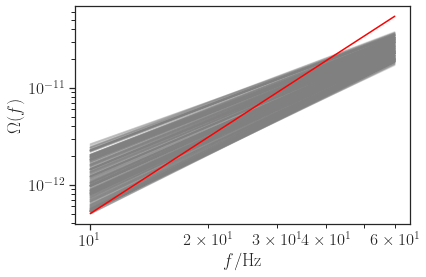

In [442]:
for i in range(500):
    plt.loglog(sim.freq, 10**prior[post_idx, 0][i] * (sim.freq/sim.fref)**prior[post_idx, 1][i], alpha=0.2, color="gray")
plt.xlabel(r"$f$/Hz")
plt.ylabel(r"$\Omega(f)$")
plt.subplots_adjust(wspace=0.5)
plt.loglog(sim.freq, 10**obs['z'][0]*(sim.freq/sim.fref)**obs['z'][1], color="red")

Text(0.5, 0, '$\\alpha$')

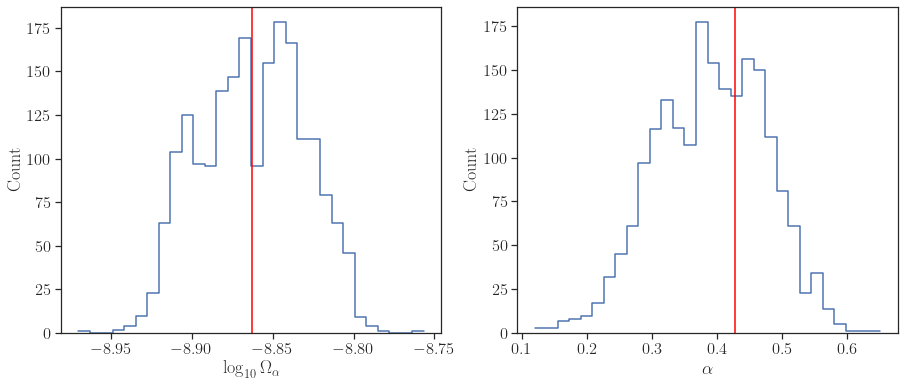

In [424]:
plt.figure(figsize=(15, 6))
plt.subplot(121)
sns.histplot(prior[post_idx, 0], bins=30, element="step", fill=False)
plt.axvline(obs['z'][0], color="red")
plt.xlabel(r"$\log_{10}\Omega_\alpha$")
plt.subplot(122)
sns.histplot(prior[post_idx, 1], bins=30, element="step", fill=False)
plt.axvline(obs['z'][1], color="red")
plt.xlabel(r"$\alpha$")

## Third Round

In [425]:
sim = Simulator(fref, CE_PSD, gamma_HL, T_obs, bounds=torch.tensor([[-8.95, -8.80], [0.1, 0.6]]))
#obs = sim.sample(conditions = {'z': np.array([5e-8, 2.1])})
samples = sim.sample(n_samples) 
samples['x'] = np.log10(np.abs(samples['x']))


100%|██████████| 10000/10000 [00:03<00:00, 2560.27it/s][A


In [426]:
x_samples = np.log10(np.abs(samples['x']))
z_samples = samples['z']

scaler_x = StandardScaler()
x_samples = scaler_x.fit_transform(x_samples)

samples['x'] = x_samples
samples['z'] = z_samples

trainer = swyft.SwyftTrainer(accelerator=DEVICE, precision=64)

# Step 4: Prepare the data module for training
dm = swyft.SwyftDataModule(samples)

# Step 5: Instantiate and train the network
network = AE()
trainer.fit(network, dm)

# Define priors
omega_prior = stats.uniform(-8.95, 0.15)  # Log-uniform distribution for omega
alpha_prior = stats.uniform(0.1, 0.5)            # Uniform distribution for alpha

obs = swyft.Sample(x=samples['x'][33], z=samples['z'][33] ) 
# Sample 1000 points from the priors
z_omega = omega_prior.rvs(20000)
z_alpha = alpha_prior.rvs(20000)

z_samps = np.column_stack((z_omega, z_alpha))

# Create prior samples
prior_samples = swyft.Samples(z = z_samps)
predictions = trainer.infer(network, obs, prior_samples)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/haowen.zhong/.conda/envs/Hierfit/lib/python3.11/site-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint

  | Name       | Type                   | Params
------------------------------------------------------
0 | summarizer | Sequential             | 2.3 M 
1 | logratios2 | LogRatioEstimator_Ndim | 34.7 K
------------------------------------------------------
2.3 M     Trainable params
0         Non-trainable params
2.3 M     Total params
18.782    Total estimated model params size (MB)


/home/haowen.zhong/.conda/envs/Hierfit/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/haowen.zhong/.conda/envs/Hierfit/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:  80%|███████▉  | 250/313 [00:09<00:02, 25.19it/s, loss=-0.905, v_num=61]
Validation: 0it [00:00, ?it/s]
Epoch 1:  80%|███████▉  | 250/313 [00:09<00:02, 26.05it/s, loss=-0.93, v_num=61, val_loss=2.380] 
Validation: 0it [00:00, ?it/s]
Epoch 2:  80%|███████▉  | 250/313 [00:09<00:02, 27.21it/s, loss=-0.944, v_num=61, val_loss=1.720]
Validation: 0it [00:00, ?it/s]
Epoch 3:  80%|███████▉  | 250/313 [00:09<00:02, 27.03it/s, loss=-1.16, v_num=61, val_loss=4.700] 
Validation: 0it [00:00, ?it/s]
Epoch 4:  80%|███████▉  | 250/313 [00:10<00:02, 23.35it/s, loss=-1.13, v_num=61, val_loss=6.980] 
Validation: 0it [00:00, ?it/s]
Epoch 5:  80%|███████▉  | 250/313 [00:11<00:02, 21.80it/s, loss=-1.13, v_num=61, val_loss=3.200]
Validation: 0it [00:00, ?it/s]
Epoch 6:  80%|███████▉  | 250/313 [00:10<00:02, 24.03it/s, loss=-1.1, v_num=61, val_loss=2.520]  
Validation: 0it [00:00, ?it/s]
Epoch 6: 100%|██████████| 313/313 [00:11<00:00, 27.78it/s, loss=-1.1, v_num=61, val_loss=5.460]


/home/haowen.zhong/.conda/envs/Hierfit/lib/python3.11/site-packages/swyft/lightning/utils.py:535: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(self.

Reloading best model: /home/haowen.zhong/SBI/SBI_SGWB_DSMMA/Haowen/lightning_logs/version_61/checkpoints/epoch=1-step=500.ckpt
Predicting DataLoader 0: 100%|██████████| 20/20 [00:01<00:00, 14.90it/s]


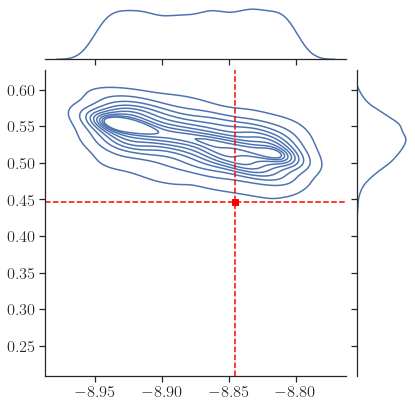

In [427]:
prior = np.asarray(predictions.params).reshape([20000,2])
ln_r_2d = np.asarray(predictions.logratios)
r_2d = np.exp(ln_r_2d).reshape(-1)
post_idx = np.random.choice(np.arange(0, 20000, 1), size=2000, p = r_2d/np.sum(r_2d))

sns.jointplot(x=prior[post_idx, 0], y=prior[post_idx, 1], kind="kde")
plt.axvline(obs['z'][0], color="red", ls="--")
plt.axhline(obs['z'][1], color="red", ls="--")
plt.plot(obs['z'][0], obs['z'][1], "s", color="red")

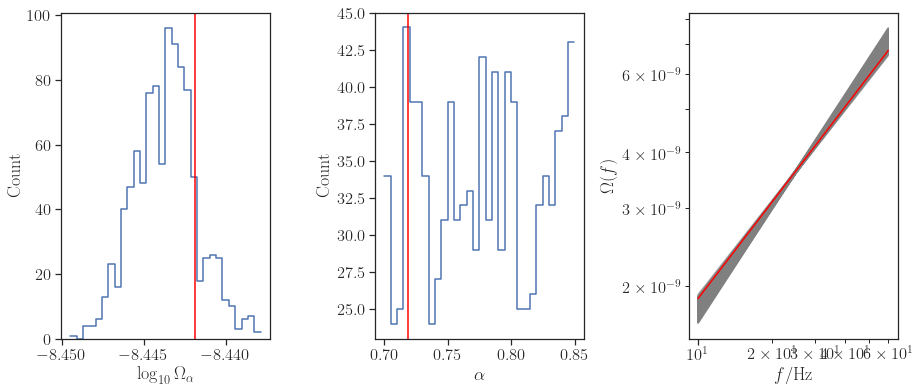

In [348]:
ln_r = np.asarray(predictions[0].logratios)
r_1 = np.exp(ln_r[:, 0])
r_2 = np.exp(ln_r[:, 1])
post_Omega = np.random.choice(z_samps[:, 0], size=1000, p = r_1/np.sum(r_1))
post_alpha = np.random.choice(z_samps[:, 1], size=1000, p = r_2/np.sum(r_2))
plt.figure(figsize=(15, 6))
plt.subplot(131)
sns.histplot(post_Omega, bins=30, element="step", fill=False)
plt.axvline(obs['z'][0], color="red")
plt.xlabel(r"$\log_{10}\Omega_\alpha$")
plt.subplot(132)
sns.histplot(post_alpha, bins=30, element="step", fill=False)
plt.axvline(obs['z'][1], color="red")
plt.xlabel(r"$\alpha$")
plt.subplot(133)
for i in range(500):
    plt.loglog(sim.freq, 10**post_Omega[i] * (sim.freq/sim.fref)**post_alpha[i], alpha=0.2, color="gray")
plt.xlabel(r"$f$/Hz")
plt.ylabel(r"$\Omega(f)$")
plt.subplots_adjust(wspace=0.5)
plt.loglog(sim.freq, 10**obs['z'][0]*(sim.freq/sim.fref)**obs['z'][1], color="red")

## Fourth Round

In [345]:
sim = Simulator(fref, CE_PSD, gamma_HL, T_obs, bounds=torch.tensor([[-8.45, -8.44], [0.7, 0.85]]))
#obs = sim.sample(conditions = {'z': np.array([5e-8, 2.1])})
samples = sim.sample(n_samples) 
samples['x'] = np.log10(np.abs(samples['x']))

100%|██████████| 10000/10000 [00:14<00:00, 691.16it/s]


In [349]:
x_samples = np.log10(np.abs(samples['x']))
z_samples = samples['z']

scaler_x = StandardScaler()
x_samples = scaler_x.fit_transform(x_samples)

samples['x'] = x_samples
samples['z'] = z_samples

trainer = swyft.SwyftTrainer(accelerator=DEVICE, precision=64)

# Step 4: Prepare the data module for training
dm = swyft.SwyftDataModule(samples)

# Step 5: Instantiate and train the network
network = AE()
trainer.fit(network, dm)

# Define priors
omega_prior = stats.uniform(-8.45, 0.01)  # Log-uniform distribution for omega
alpha_prior = stats.uniform(0.7, 0.15)            # Uniform distribution for alpha

obs = swyft.Sample(x=samples['x'][20], z=samples['z'][20] ) 
# Sample 1000 points from the priors
z_omega = omega_prior.rvs(20000)
z_alpha = alpha_prior.rvs(20000)

z_samps = np.column_stack((z_omega, z_alpha))

# Create prior samples
prior_samples = swyft.Samples(z = z_samps)
predictions = trainer.infer(network, obs, prior_samples)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/haowen.zhong/.conda/envs/Hierfit/lib/python3.11/site-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint

  | Name       | Type                   | Params
------------------------------------------------------
0 | summarizer | Sequential             | 2.3 M 
1 | logratios1 | LogRatioEstimator_1dim | 69.2 K
2 | logratios2 | LogRatioEstimator_Ndim | 34.7 K
------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
19.336    Total estimated model params size (MB)


/home/haowen.zhong/.conda/envs/Hierfit/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/haowen.zhong/.conda/envs/Hierfit/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:  80%|███████▉  | 250/313 [00:15<00:03, 15.78it/s, loss=-1.34, v_num=49]  
Validation: 0it [00:00, ?it/s]
Epoch 1:  80%|███████▉  | 250/313 [00:14<00:03, 17.35it/s, loss=-1.63, v_num=49, val_loss=17.20]
Validation: 0it [00:00, ?it/s]
Epoch 2:  80%|███████▉  | 250/313 [00:14<00:03, 16.90it/s, loss=-1.66, v_num=49, val_loss=3.170]
Validation: 0it [00:00, ?it/s]
Epoch 3:  80%|███████▉  | 250/313 [00:14<00:03, 17.35it/s, loss=-1.9, v_num=49, val_loss=0.661] 
Validation: 0it [00:00, ?it/s]
Epoch 4:  80%|███████▉  | 250/313 [00:14<00:03, 17.29it/s, loss=-1.89, v_num=49, val_loss=3.340]
Validation: 0it [00:00, ?it/s]
Epoch 5:  80%|███████▉  | 250/313 [00:14<00:03, 16.81it/s, loss=-2.02, v_num=49, val_loss=2.430]
Validation: 0it [00:00, ?it/s]
Epoch 6:  80%|███████▉  | 250/313 [00:15<00:03, 16.03it/s, loss=-2.08, v_num=49, val_loss=-1.69]
Validation: 0it [00:00, ?it/s]
Epoch 7:  80%|███████▉  | 250/313 [00:17<00:04, 13.98it/s, loss=-2.05, v_num=49, val_loss=-.216]
Validation: 0it [00:0

/home/haowen.zhong/.conda/envs/Hierfit/lib/python3.11/site-packages/swyft/lightning/utils.py:535: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(self.

Reloading best model: /home/haowen.zhong/SBI/SBI_SGWB_DSMMA/Haowen/lightning_logs/version_49/checkpoints/epoch=5-step=1500.ckpt
Predicting DataLoader 0: 100%|██████████| 20/20 [00:02<00:00,  8.38it/s]


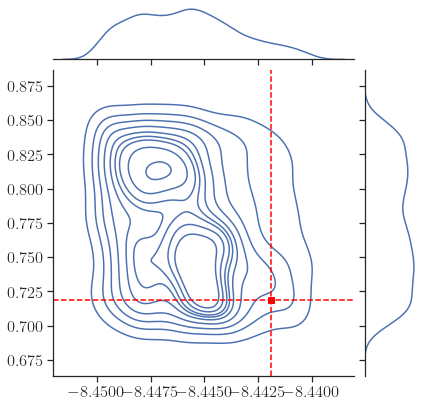

In [352]:
prior = np.asarray(predictions[1].params).reshape([20000,2])
ln_r_2d = np.asarray(predictions[1].logratios)
r_2d = np.exp(ln_r_2d).reshape(-1)
post_idx = np.random.choice(np.arange(0, 20000, 1), size=2000, p = r_2d/np.sum(r_2d))

sns.jointplot(x=prior[post_idx, 0], y=prior[post_idx, 1], kind="kde")
plt.axvline(obs['z'][0], color="red", ls="--")
plt.axhline(obs['z'][1], color="red", ls="--")
plt.plot(obs['z'][0], obs['z'][1], "s", color="red")

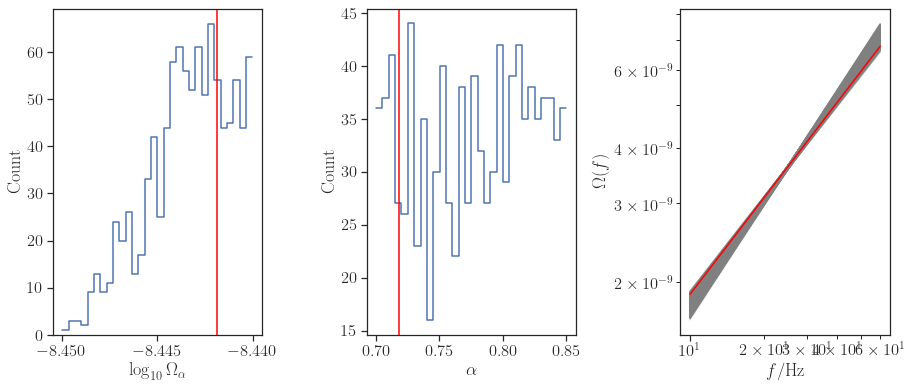

In [353]:
ln_r = np.asarray(predictions[0].logratios)
r_1 = np.exp(ln_r[:, 0])
r_2 = np.exp(ln_r[:, 1])
post_Omega = np.random.choice(z_samps[:, 0], size=1000, p = r_1/np.sum(r_1))
post_alpha = np.random.choice(z_samps[:, 1], size=1000, p = r_2/np.sum(r_2))
plt.figure(figsize=(15, 6))
plt.subplot(131)
sns.histplot(post_Omega, bins=30, element="step", fill=False)
plt.axvline(obs['z'][0], color="red")
plt.xlabel(r"$\log_{10}\Omega_\alpha$")
plt.subplot(132)
sns.histplot(post_alpha, bins=30, element="step", fill=False)
plt.axvline(obs['z'][1], color="red")
plt.xlabel(r"$\alpha$")
plt.subplot(133)
for i in range(500):
    plt.loglog(sim.freq, 10**post_Omega[i] * (sim.freq/sim.fref)**post_alpha[i], alpha=0.2, color="gray")
plt.xlabel(r"$f$/Hz")
plt.ylabel(r"$\Omega(f)$")
plt.subplots_adjust(wspace=0.5)
plt.loglog(sim.freq, 10**obs['z'][0]*(sim.freq/sim.fref)**obs['z'][1], color="red")

# TMNRE

In [354]:
import numpy as np
import pylab as plt
import torch
import scipy.stats as stats
import scipy
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import swyft
import random
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader



DEVICE = 'gpu' if torch.cuda.is_available() else 'cpu'

# Define simulator parameters
f_low = 10
f_high = 60
N_bins = 1600
freq = np.linspace(f_low, f_high, N_bins)
pi = np.pi
sqrt = np.sqrt
H100 = 3.241e-18
h    = 0.679
H0   = h * H100

# Define Simulator
class Simulator(swyft.Simulator):
    def __init__(self, fref, psd, gamma, T_obs, Nbins=len(freq), bounds=None):
        super().__init__()
        
        self.fref      = fref
        self.psd       = psd
        self.gamma     = gamma
        self.T_obs     = T_obs
        
        self.transform_samples = swyft.to_numpy32
        self.Nbins = Nbins
        self.freq = np.linspace(f_low, f_high, N_bins)
        self.sample_z = swyft.RectBoundSampler([stats.uniform(-12,5), #omega
                                                stats.uniform(0,3)], #alpha
                                                bounds = bounds) #bounds changes range of the prior

    def psd_interp(self):
        return scipy.interpolate.interp1d(self.psd[:,0], self.psd[:,1])(self.freq)
    
    def gamma_interp(self):
        return scipy.interpolate.interp1d(self.gamma[:, 0], self.gamma[:, 1])(self.freq)
    
    def sigma(self):
        numerator = (20*pi**2*self.freq**3)**2 * self.psd_interp()**2
        denomenator = (3*H0**2)**2 * 8*self.gamma_interp()**2
        T = 1/(self.freq[1]-self.freq[0])
        N = 2*self.T_obs // T - 1
        return np.sqrt(numerator/denomenator/N)
    
    def C_groundtruth(self, z):
        Omega_ref = 10**z[0]
        alpha     = z[1]
        C_hat_ij = Omega_ref * (self.freq/self.fref)**alpha
        return C_hat_ij
    
    def build(self, graph):
        z = graph.node('z', self.sample_z)
        m = graph.node('m', self.C_groundtruth, z)
        x = graph.node("x", lambda m: m + np.random.normal(0, self.sigma()), m)
        #x = graph.node("x", lambda m: m + 0, m) #Ground truth wih sigma noise
        sigma = graph.node('sigma',self.sigma)

In [372]:
#implement T M N R E 
# Define priors
n_samples = 5000
omega_prior = stats.uniform(-12, 5)  # Log-uniform distribution for omega
alpha_prior = stats.uniform(0, 3)            # Uniform distribution for alpha


def round(obs,  fref, CE_PSD, gamma_HL, T_obs, bounds = None):
    sim = Simulator(fref, CE_PSD, gamma_HL, T_obs, bounds=bounds)
    samples = sim.sample(n_samples)

    x_samples = np.log10(np.abs(samples['x']))
    scaler_x = StandardScaler()
    x_samples = scaler_x.fit_transform(x_samples)

    samples['x'] = x_samples
    
    # Initialize trainer and network 
    trainer = swyft.SwyftTrainer(accelerator=DEVICE, precision=64)
    dm = swyft.SwyftDataModule(samples)
    network = AE()
    trainer.fit(network, dm)
  

    # Sample from the priors
    # if bounds != None:
    #     omega_prior = stats.uniform(bounds[0][0], bounds[0][1]-bounds[0][0])
    #     alpha_prior = stats.uniform(bounds[1][0], bounds[1][1]-bounds[1][0])
    # z_omega = omega_prior.rvs(20000)
    # z_alpha = alpha_prior.rvs(20000)
    #z_samps = np.column_stack((z_omega, z_alpha))

    # Create prior samples
    prior_samples = sim.sample(n_samples, targets = ['z'])


    # Perform inference
    predictions = trainer.infer(network, obs, prior_samples)
    #print("Predictions logratios:", predictions.logratios)

    new_bounds = swyft.collect_rect_bounds(predictions[0], 'z', (2,), threshold=1e-6)

    print("Returning from round():", predictions, bounds, samples)  # Debug print
    return predictions, new_bounds, samples


In [374]:
obs = swyft.Sample(x=samples['x'][33], z=samples['z'][33] ) 
obs

Sample({'x': array([ 0.8553225 ,  0.24309711, -1.467671  , ..., -3.3394494 ,
       -0.13392526, -4.536267  ], dtype=float32), 'z': array([-11.05075  ,   1.7474399], dtype=float32)})

In [375]:
bounds = None
prediction_rounds = []
bounds_rounds = []
samples_rounds = []

for n in range(4):
    predictions, bounds, samples = round(obs, fref, CE_PSD, gamma_HL, T_obs, bounds = bounds)
    prediction_rounds.append(predictions)
    bounds_rounds.append(bounds)
    samples_rounds.append(samples)
    print("New bounds:", bounds)

100%|██████████| 5000/5000 [00:07<00:00, 671.26it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/haowen.zhong/.conda/envs/Hierfit/lib/python3.11/site-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint

  | Name       | Type                   | Params
------------------------------------------------------
0 | summarizer | Sequential             | 2.3 M 
1 | logratios1 | LogRatioEstimator_1dim | 69.2 K
2 | logratios2 | LogRatioEstimator_Ndim | 34.7 K
------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
19.336    Total

Sanity Checking: 0it [00:00, ?it/s]

/home/haowen.zhong/.conda/envs/Hierfit/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/haowen.zhong/.conda/envs/Hierfit/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:  80%|███████▉  | 125/157 [00:08<00:02, 14.75it/s, loss=-1.93, v_num=54]
Validation: 0it [00:00, ?it/s]
Epoch 1:  80%|███████▉  | 125/157 [00:08<00:02, 15.00it/s, loss=-1.98, v_num=54, val_loss=-2.04]
Validation: 0it [00:00, ?it/s]
Epoch 2:  80%|███████▉  | 125/157 [00:07<00:01, 16.07it/s, loss=-2.13, v_num=54, val_loss=-2.01]
Validation: 0it [00:00, ?it/s]
Epoch 3:  80%|███████▉  | 125/157 [00:07<00:02, 15.78it/s, loss=-2.15, v_num=54, val_loss=-2.07]
Validation: 0it [00:00, ?it/s]
Epoch 4:  80%|███████▉  | 125/157 [00:08<00:02, 15.58it/s, loss=-2.16, v_num=54, val_loss=-1.63]
Validation: 0it [00:00, ?it/s]
Epoch 5:  80%|███████▉  | 125/157 [00:07<00:01, 16.29it/s, loss=-2.09, v_num=54, val_loss=2.910]
Validation: 0it [00:00, ?it/s]
Epoch 6:  80%|███████▉  | 125/157 [00:07<00:01, 16.26it/s, loss=-2.06, v_num=54, val_loss=-.758]
Validation: 0it [00:00, ?it/s]
Epoch 7:  80%|███████▉  | 125/157 [00:08<00:02, 14.89it/s, loss=-2.34, v_num=54, val_loss=1.680]
Validation: 0it [00:00,

/home/haowen.zhong/.conda/envs/Hierfit/lib/python3.11/site-packages/swyft/lightning/utils.py:535: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(self.

Reloading best model: /home/haowen.zhong/SBI/SBI_SGWB_DSMMA/Haowen/lightning_logs/version_54/checkpoints/epoch=2-step=375.ckpt


100%|██████████| 5000/5000 [00:01<00:00, 3646.11it/s]
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 11.08it/s]
Returning from round(): [LogRatioSamples(logratios=tensor([[-1.0698e+01, -4.1675e-03],
        [-1.0768e+01, -5.5821e-03],
        [-3.7463e+00, -4.1568e-03],
        ...,
        [-9.3696e+00, -6.4933e-03],
        [-1.0553e+01, -6.3616e-03],
        [-1.0206e+00, -6.4651e-03]], dtype=torch.float64), params=tensor([[[-11.4385],
         [  1.0388]],

        [[-11.4833],
         [  2.2764]],

        [[ -9.5481],
         [  1.0256]],

        ...,

        [[ -8.0600],
         [  2.7200]],

        [[-11.3459],
         [  2.8804]],

        [[ -9.1220],
         [  2.7544]]], dtype=torch.float64), parnames=array([['z[0]'],
       ['z[1]']], dtype='<U4'), metadata={}), LogRatioSamples(logratios=tensor([[-8.4362],
        [-8.4917],
        [-4.3163],
        ...,
        [-8.7023],
        [-8.3426],
        [ 1.5083]], dtype=torch.float64), params=tensor([[[-11.4385,   1.0388]],

        [[-11.4833,   2.2764]],

100%|██████████| 5000/5000 [00:07<00:00, 665.29it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/haowen.zhong/.conda/envs/Hierfit/lib/python3.11/site-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint

  | Name       | Type                   | Params
------------------------------------------------------
0 | summarizer | Sequential             | 2.3 M 
1 | logratios1 | LogRatioEstimator_1dim | 69.2 K
2 | logratios2 | LogRatioEstimator_Ndim | 34.7 K
------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
19.336    Total

/home/haowen.zhong/.conda/envs/Hierfit/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/haowen.zhong/.conda/envs/Hierfit/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:  80%|███████▉  | 125/157 [00:08<00:02, 14.00it/s, loss=-1.97, v_num=55] 
Validation: 0it [00:00, ?it/s]
Epoch 1:  80%|███████▉  | 125/157 [00:08<00:02, 14.09it/s, loss=-1.95, v_num=55, val_loss=-1.25]
Validation: 0it [00:00, ?it/s]
Epoch 2:  80%|███████▉  | 125/157 [00:08<00:02, 14.03it/s, loss=-1.93, v_num=55, val_loss=-1.50]
Validation: 0it [00:00, ?it/s]
Epoch 3:  80%|███████▉  | 125/157 [00:08<00:02, 15.17it/s, loss=-2.25, v_num=55, val_loss=-.335]
Validation: 0it [00:00, ?it/s]
Epoch 4:  80%|███████▉  | 125/157 [00:08<00:02, 14.81it/s, loss=-2.24, v_num=55, val_loss=-1.93]
Validation: 0it [00:00, ?it/s]
Epoch 5:  80%|███████▉  | 125/157 [00:08<00:02, 15.46it/s, loss=-2.2, v_num=55, val_loss=-2.19] 
Validation: 0it [00:00, ?it/s]
Epoch 6:  80%|███████▉  | 125/157 [00:08<00:02, 15.28it/s, loss=-2.24, v_num=55, val_loss=-2.11]
Validation: 0it [00:00, ?it/s]
Epoch 7:  80%|███████▉  | 125/157 [00:07<00:02, 15.85it/s, loss=-2.24, v_num=55, val_loss=-1.57]
Validation: 0it [00:00

/home/haowen.zhong/.conda/envs/Hierfit/lib/python3.11/site-packages/swyft/lightning/utils.py:535: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(self.

Reloading best model: /home/haowen.zhong/SBI/SBI_SGWB_DSMMA/Haowen/lightning_logs/version_55/checkpoints/epoch=4-step=625.ckpt


100%|██████████| 5000/5000 [00:01<00:00, 3871.03it/s]
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 14.43it/s]
Returning from round(): [LogRatioSamples(logratios=tensor([[-10.3918,  -0.0171],
        [-10.0284,  -0.0252],
        [-10.6402,  -0.0254],
        ...,
        [-10.1852,  -0.0221],
        [ -3.0198,  -0.0247],
        [-10.5543,  -0.0239]], dtype=torch.float64), params=tensor([[[ -7.6740],
         [  0.5364]],

        [[-10.8322],
         [  0.9034]],

        [[-11.2966],
         [  2.4506]],

        ...,

        [[-10.9546],
         [  0.7536]],

        [[ -9.1227],
         [  2.6055]],

        [[-11.2417],
         [  2.7861]]], dtype=torch.float64), parnames=array([['z[0]'],
       ['z[1]']], dtype='<U4'), metadata={}), LogRatioSamples(logratios=tensor([[ -9.1649],
        [ -9.9588],
        [-11.0672],
        ...,
        [-10.2608],
        [ -1.4989],
        [-10.9258]], dtype=torch.float64), params=tensor([[[ -7.6740,   0.5364]],

        [[-10.8322,   0.9034]],

        [[-11.2966,   2.4506

100%|██████████| 5000/5000 [00:07<00:00, 677.61it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/haowen.zhong/.conda/envs/Hierfit/lib/python3.11/site-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint

  | Name       | Type                   | Params
------------------------------------------------------
0 | summarizer | Sequential             | 2.3 M 
1 | logratios1 | LogRatioEstimator_1dim | 69.2 K
2 | logratios2 | LogRatioEstimator_Ndim | 34.7 K
------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
19.336    Total

/home/haowen.zhong/.conda/envs/Hierfit/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/haowen.zhong/.conda/envs/Hierfit/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:  80%|███████▉  | 125/157 [00:08<00:02, 14.82it/s, loss=-2.01, v_num=56] 
Validation: 0it [00:00, ?it/s]
Epoch 1:  80%|███████▉  | 125/157 [00:08<00:02, 15.53it/s, loss=-2.18, v_num=56, val_loss=-1.74]
Validation: 0it [00:00, ?it/s]
Epoch 2:  80%|███████▉  | 125/157 [00:08<00:02, 14.20it/s, loss=-1.97, v_num=56, val_loss=-.483]
Validation: 0it [00:00, ?it/s]
Epoch 3:  27%|██▋       | 43/157 [00:02<00:07, 14.64it/s, loss=-2.03, v_num=56, val_loss=-1.92] 

/home/haowen.zhong/.conda/envs/Hierfit/lib/python3.11/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")

 22%|██▏       | 1079/5000 [00:00<00:01, 3429.88it/s]

KeyboardInterrupt



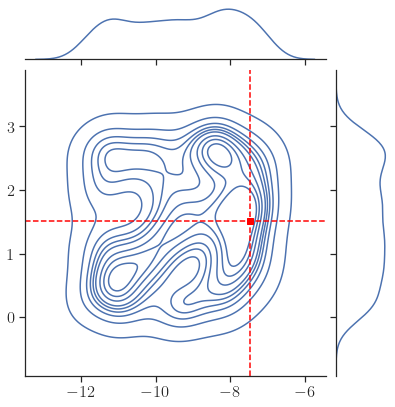

In [360]:
prior = np.asarray(prediction_rounds[0][1].params).reshape([5000,2])
ln_r_2d = np.asarray(prediction_rounds[1][1].logratios)
r_2d = np.exp(ln_r_2d).reshape(-1)
post_idx = np.random.choice(np.arange(0, 5000, 1), size=500, p = r_2d/np.sum(r_2d))

sns.jointplot(x=prior[post_idx, 0], y=prior[post_idx, 1], kind="kde")
plt.axvline(truth['z[0]'], color="red", ls="--")
plt.axhline(truth['z[1]'], color="red", ls="--")
plt.plot(truth['z[0]'], truth['z[1]'], "s", color="red")

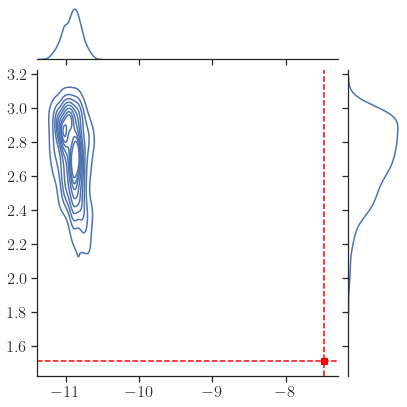

In [361]:
prior = np.asarray(prediction_rounds[1][1].params).reshape([5000,2])
ln_r_2d = np.asarray(prediction_rounds[1][1].logratios)
r_2d = np.exp(ln_r_2d).reshape(-1)
post_idx = np.random.choice(np.arange(0, 5000, 1), size=500, p = r_2d/np.sum(r_2d))

sns.jointplot(x=prior[post_idx, 0], y=prior[post_idx, 1], kind="kde")
plt.axvline(truth['z[0]'], color="red", ls="--")
plt.axhline(truth['z[1]'], color="red", ls="--")
plt.plot(truth['z[0]'], truth['z[1]'], "s", color="red")

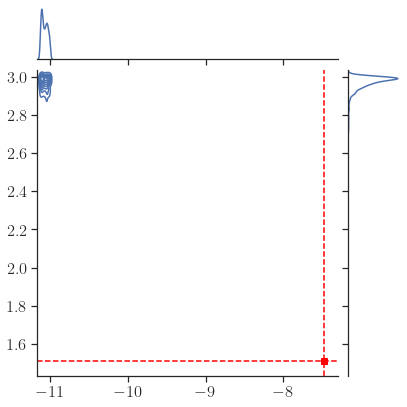

In [363]:
prior = np.asarray(prediction_rounds[3][1].params).reshape([5000,2])
ln_r_2d = np.asarray(prediction_rounds[3][1].logratios)
r_2d = np.exp(ln_r_2d).reshape(-1)
post_idx = np.random.choice(np.arange(0, 5000, 1), size=500, p = r_2d/np.sum(r_2d))

sns.jointplot(x=prior[post_idx, 0], y=prior[post_idx, 1], kind="kde")
plt.axvline(truth['z[0]'], color="red", ls="--")
plt.axhline(truth['z[1]'], color="red", ls="--")
plt.plot(truth['z[0]'], truth['z[1]'], "s", color="red")

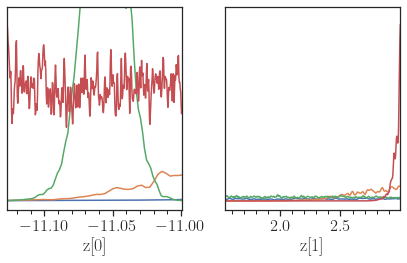

In [368]:
truth = {k: v for k, v in zip(["z[%i]"%i for i in range(2)], obs['z'])}
color=["#4c72b0", "#dd8452", "#55a868", "#c44e52"]
fig = None
for i in range(0, 4):
    fig = swyft.plot_posterior(prediction_rounds[i], ["z[%i]"%i for i in range(2)], fig=fig, truth=truth, smooth = 1, color=color[i], bins = 400, contours = False)

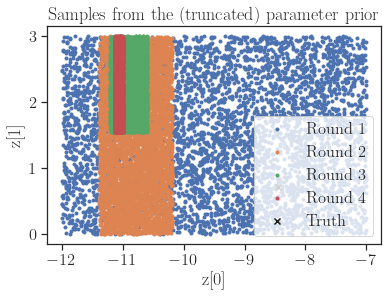

In [369]:
plt.scatter(samples_rounds[0]['z'][:,0], samples_rounds[0]['z'][:,1], color = color[0], label = 'Round 1', marker = '.')
plt.scatter(samples_rounds[1]['z'][:,0], samples_rounds[1]['z'][:,1], color = color[1], label = "Round 2", marker = '.')
plt.scatter(samples_rounds[2]['z'][:,0], samples_rounds[2]['z'][:,1], color = color[2], label = 'Round 3', marker = '.')
plt.scatter(samples_rounds[3]['z'][:,0], samples_rounds[3]['z'][:,1], color = color[3], label = 'Round 4', marker = '.')

plt.scatter(obs['z'][0], obs['z'][1], marker = 'x', color='k', label = 'Truth')
plt.legend()
plt.xlabel("z[0]"); plt.ylabel("z[1]")
plt.title("Samples from the (truncated) parameter prior");

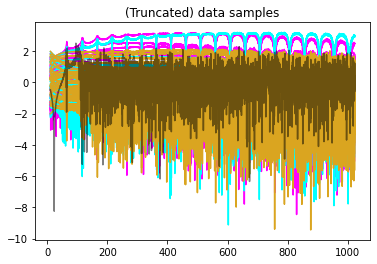

In [67]:
for i, color in enumerate(['fuchsia', 'cyan', 'goldenrod']):
    for j in range(50):
        plt.plot(sim.freq, samples_rounds[i]['x'][j], color = color)
plt.plot(sim.freq, obs['x'], color = 'k', alpha = 0.5)
#plt.ylim([-1, 1])
plt.title("(Truncated) data samples");